In [26]:
import pandas as pd
from tqdm import tqdm  
import time 
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize  
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
import math
import statistics
import seaborn as sns
from sklearn import preprocessing

In [20]:
df=pd.read_csv(r'C:\Users\Windows\Desktop\Spotify_Dataset_V3.csv',delimiter=';')
df_noURL=df.iloc[:,0:-1]
url=df.iloc[:,-1]

In [31]:
# Creat a daily average data of each feature
df_nodup = df_noURL.loc[:,['Title','Artists','Date','Danceability','Energy','Loudness','Speechiness','Acousticness','Instrumentalness','Valence']]
df_nodup = df_nodup.drop_duplicates(subset=['Title','Artists','Date'])
df_nodup = df_nodup.drop('Artists', axis=1)
df_nodup = df_nodup.iloc[::-1]
Date = [];Mean_dance=[];Mean_energy=[];Mean_loud=[];Mean_speech=[];Mean_acoustic=[];Mean_instru=[];Mean_valence=[]
Var_dance=[];Var_energy=[];Var_loud=[];Var_speech=[];Var_acoustic=[];Var_instru=[];Var_valence=[]
i=199;k=0
while (df_nodup.shape[0]-i)> 0:
    date=datetime.strptime(df_nodup.iloc[i,1],'%d/%m/%Y').strftime('%Y-%m-%d')
    if i>200:
        if date == Date[-1]:
            k=k+1
            i=i+1
            continue
    Date.append(date)
    df_mean=df_nodup.iloc[i-199-k:i,2:].mean()
    df_var=df_nodup.iloc[i-199-k:i,2:].var()
    Mean_dance.append(df_mean.iloc[0]);Var_dance.append(df_var.iloc[0])
    Mean_energy.append(df_mean.iloc[1]);Var_energy.append(df_var.iloc[1])
    Mean_loud.append(df_mean.iloc[2]);Var_loud.append(df_var.iloc[2])
    Mean_speech.append(df_mean.iloc[3]);Var_speech.append(df_var.iloc[3])
    Mean_acoustic.append(df_mean.iloc[4]);Var_acoustic.append(df_var.iloc[4])
    Mean_instru.append(df_mean.iloc[5]);Var_instru.append(df_var.iloc[5])
    Mean_valence.append(df_mean.iloc[6]);Var_valence.append(df_var.iloc[6])
    i+=200
    k=0
daily_mean = {'Mean_dance': Mean_dance,'Mean_energy':Mean_energy,'Mean_loud':Mean_loud,'Mean_speech':Mean_speech,'Mean_acoustic':Mean_acoustic,'Mean_instru':Mean_instru,'Mean_valence':Mean_valence}
dailymean_df = pd.DataFrame(data=daily_mean)
daily_var = {'Var_dance': Var_dance,'Var_energy':Var_energy,'Var_loud':Var_loud,'Var_speech':Var_speech,'Var_acoustic':Var_acoustic,'Var_instru':Var_instru,'Var_valence':Var_valence}
dailyvar_df = pd.DataFrame(data=daily_var)

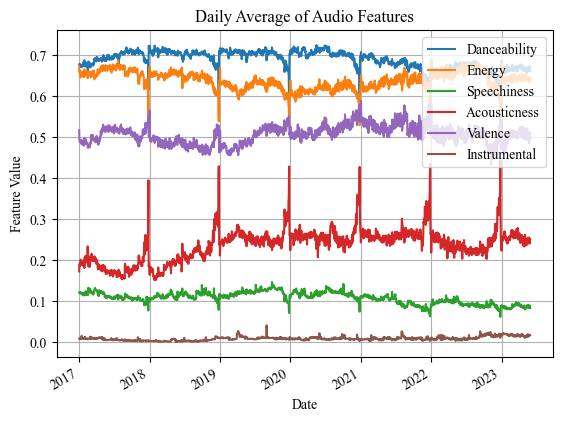

In [34]:
date_time = pd.to_datetime(Date)
scaler = preprocessing.MinMaxScaler()
plt.rcParams['font.family']='Times New Roman'
#the ieee style will override some of the parameters from the science style in order to configure the plot for IEEE papers (column width, fontsizes, etc.).
fig = plt.figure()
plt.plot(date_time,Mean_dance)
plt.plot(date_time,Mean_energy)
plt.plot(date_time,Mean_speech)
plt.plot(date_time,Mean_acoustic)
plt.plot(date_time,Mean_valence)
plt.plot(date_time,Mean_instru)
my_labels = ['Danceability', 'Energy', 'Speechiness', 'Acousticness','Valence','Instrumental']  
plt.title('Daily Average of Audio Features')
plt.legend(my_labels,loc='upper right')
plt.xlabel('Date')  
plt.ylabel('Feature Value')  
plt.grid()  
plt.gcf().autofmt_xdate()
plt.show()
fig.savefig('C:/Users/Windows/Desktop/Mean.png')

In [64]:
filtered_df = dailymean_df.loc[dailymean_df['Mean_dance'] < 0.62]

In [65]:
filtered_df
# Christmas!!

,Date,Mean_dance,Mean_energy,Mean_loud,Mean_speech,Mean_acoustic,Mean_instru,Mean_valence
355,2017-12-26,0.615981,0.547325,-7754.633495,0.077796,0.394772,0.003194,0.550694
719,2018-12-25,0.614697,0.550875,-7182.036250,0.079303,0.403582,0.009832,0.527769
720,2018-12-26,0.603402,0.538703,-7519.199091,0.079541,0.429057,0.009928,0.528450
1084,2019-12-25,0.608851,0.541817,-7151.091827,0.072236,0.405207,0.006048,0.551024
1085,2019-12-26,0.592742,0.527809,-7603.234450,0.071282,0.428459,0.006100,0.546033
1450,2020-12-25,0.597177,0.538254,-7423.150048,0.074512,0.425703,0.003220,0.578751
1451,2020-12-26,0.598651,0.529077,-7683.675263,0.075153,0.427368,0.003053,0.574569
1814,2021-12-24,0.618362,0.598668,-6348.762613,0.069724,0.364452,0.007367,0.559417
1815,2021-12-25,0.583307,0.564915,-7123.417236,0.063070,0.413085,0.003402,0.567925
1816,2021-12-26,0.567271,0.560980,-7361.093518,0.063824,0.435161,0.008075,0.567945


The methology of the Holt-model is that instead of using simple moving average model, it adds trend factor and seasonal factor. The train-test dataset is within 2022.1.1-2022.12.31 in a K-fold way. And the validate process is using dataset from 2023.1.1-2023.5.22, we use one month to predict the following weeks data,so we will have 112 times validation, and using the mean mse as the accuracy.

In [30]:
# Holt-Winters
Daily_mean = {'Mean_dance': Mean_dance,'Mean_energy':Mean_energy,'Mean_speech':Mean_speech,'Mean_acoustic':Mean_acoustic,'Mean_instru':Mean_instru,'Mean_valence':Mean_valence}
Dailydata = pd.DataFrame(data=Daily_mean)

In [31]:
if __name__ == '__main__':
    mse_all={}
    for j in range(Dailydata.shape[1]):
        name = Dailydata.columns[j]
        data = Dailydata.iloc[:,j]
        # initializing model parameters alpha, beta and gamma
        cycle = 7
        pre_len = 7
        # Train and test
        Train_test_data=data.iloc[1822:2306-119].reset_index(drop=True)#2022..1.1-2022.12.31
        #Validation
        Validate_data=data.iloc[2306-119:-7].reset_index(drop=True)#2023.1.1-2023.5.22
        Result_data=data.iloc[2306-119:].reset_index(drop=True)#2023.1.1-2023.5.29 the data from model.result contains 7 days of pure prediction
        # Minimizing the loss function
        opt = minimize(timeseriesCVscore, x0=[0, 0, 0],
                    args=(Train_test_data, mean_squared_error,),
                    method='Nelder-Mead'  , bounds=((0, 1), (0, 1), (0, 1))
                    )
        print('Finished opt!')
        # Take optimal values...
        alpha, beta, gamma = opt.x
        print(opt.fun)
        mse=[]
        for i in range(Validate_data.shape[0]-30): 
            model = HoltWinters(Validate_data[i:i+30].reset_index(drop=True), slen=cycle,
                                alpha=alpha,
                                beta=beta,
                                gamma=gamma,
                                n_preds=pre_len, scaling_factor=2)
            model.triple_exponential_smoothing()
            mse.append(round((Result_data[i+30:i+37].reset_index(drop=True)-model.result[30:]).pow(2).mean(),10))#MSE
            mse_all[name]=pd.DataFrame(mse).mean()
    #'Nelder-Mead':0.004047127043766115 Good! 0.0000051 0.0000152
     #'Nelder-Mead' with 6 folds: 0.0026186684065304493 Good! 0.0000051 0.0000152
    #'L-BFGS-B': 0.0006596200731843452 Good! 0.000006
    #'CG': 0.0004136189785127483 Good! 0.000006
    #'Powell': 0.0008448604549845748 Not as good 0.00001
    #'trust-constr':0.0006010416317593148 Not as good 0.000005
    #'COBYLA' :0.00042636367356643963 Not as good 0.000008
    #'SLSQP':0.00043942046646299046 Bad! 0.000019
    #'TNC': 0.00036063312123996047 Bad! 0.000023

Finished opt!
0.0011816422065239827
Finished opt!
0.0013279358202436435
Finished opt!
0.000260899746860911
Finished opt!
0.0010114315399553208
Finished opt!
4.5340755768081794e-05
Finished opt!
0.007390313666184456


In [32]:
pd.DataFrame(data=mse_all)

,Mean_dance,Mean_energy,Mean_speech,Mean_acoustic,Mean_instru,Mean_valence
0,0.00002,0.000035,0.000012,0.000085,0.000007,0.000068


The algorithm has a good fitting to the data, and can show the trend and periodic features which can be applied to predictions in a large scale

In [33]:
mse_all

{'Mean_dance': 0    0.00002
 dtype: float64,
 'Mean_energy': 0    0.000035
 dtype: float64,
 'Mean_speech': 0    0.000012
 dtype: float64,
 'Mean_acoustic': 0    0.000085
 dtype: float64,
 'Mean_instru': 0    0.000007
 dtype: float64,
 'Mean_valence': 0    0.000068
 dtype: float64}

In [28]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize   
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
                        

class HoltWinters:# Optimized MA Model
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
 
    def initial_trend(self):
        """
        
        initial_trend,using the data in the first period 
        :return: initial_trend
        """
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i + self.slen] - self.series[i]) / self.slen
        return sum / self.slen
 
    def initial_seasonal_components(self):
        """
        initial_seasonal_components
        :return: Season effects on periodic averages
        """
        seasonals = {}
        season_averages = []
        # Number of season
        n_seasons = int(len(self.series) / self.slen)
        # season averages
        for j in range(n_seasons):
            season_averages.append(np.mean(self.series[self.slen * j:self.slen * j + self.slen]))
        # nitial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen * j + i] - season_averages[j]
            seasonals[i] = sum_of_vals_over_avg / n_seasons
        return seasonals
 
    def triple_exponential_smoothing(self):
        """
        triple_exponential_smoothing
        :return:
        """
        # Prediction
        self.result = []
        # Smoothing
        self.Smooth = []
        # Season
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        seasonals = self.initial_seasonal_components()
 
        for i in range(len(self.series) + self.n_preds):
            if i == 0:  # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i % self.slen])
 
                self.PredictedDeviation.append(0)
 
                self.UpperBond.append(self.result[0] +
                                      self.scaling_factor *
                                      self.PredictedDeviation[0])
 
                self.LowerBond.append(self.result[0] -
                                      self.scaling_factor *
                                      self.PredictedDeviation[0])
                continue
 
            if i >= len(self.series):  # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m * trend) + seasonals[i % self.slen])
                # self.result.append(max(0,min(1, (smooth + m * trend) + seasonals[i % self.slen])))
 
                # increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1] * 1.01)
 
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha * (val - seasonals[i % self.slen]) + (1 - self.alpha) * (
                        smooth + trend)
                trend = self.beta * (smooth - last_smooth) + (1 - self.beta) * trend
                seasonals[i % self.slen] = self.gamma * (val - smooth) + (1 - self.gamma) * seasonals[i % self.slen]
                self.result.append(smooth + trend + seasonals[i % self.slen])
                # self.result.append(max(0,min(1, smooth + trend + seasonals[i % self.slen])))
 
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i])
                                               + (1 - self.gamma) * self.PredictedDeviation[-1])
 
            self.UpperBond.append(self.result[-1] +
                                  self.scaling_factor *
                                  self.PredictedDeviation[-1])
 
            self.LowerBond.append(self.result[-1] -
                                  self.scaling_factor *
                                  self.PredictedDeviation[-1])
 
            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])
 
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=7):
    """
        Returns error on CV
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
 
    values = series.values
    alpha, beta, gamma = params
 
    # set the number of folds for cross-validation
    # tscv = TimeSeriesSplit(n_splits=50, test_size=4)
    tscv = TimeSeriesSplit(n_splits=8)
 
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):
        model = HoltWinters(series=values[train], slen=slen,
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
 
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
 
    return np.mean(np.array(errors))  # mean errors
